# Main Goals

Given a dataset containing Hebrew posts from social media, **predict whether a post has violent sentiment (tag == 1) or not (tag == 0)**. 

The output should be a text\csv file which contains a single column with the prediction (0 or 1) for each one of the test samples. Each prediction in the output file should be in a separate row. The **test data is considered as an UNSEEN dataset,** which is available only for calculating your predictions. 

Assumption on the Objectif:
In the context of hate speech in social medias, it is very importante to be able to detect it. **Our strategy here is to maximize the detection of harmfull speeches while guaranteeing a good accuracy with preserving the other speeches**.

We will considerate only the Feature Text and Tag for the classification to focus on the detection base on the text only.

Steps:
1. Data Cleaning and Processing
2. Data Analysis to look for some insights 
3. Oversampling the minor class
4. Classification


# Packages

In [1]:
import os
import numpy as np
import pandas as pd
from collections import Counter
from collections import defaultdict
import matplotlib.pyplot as plt
from random import sample
from numpy.random import uniform
import numpy as np
from math import isnan
import string
import re
# from google.colab import drive, files
import io
import matplotlib.pyplot as plt


from gensim import utils
import gensim.parsing.preprocessing as gsp

from sklearn.model_selection import KFold
from sklearn.utils.multiclass import unique_labels
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB, ComplementNB
from sklearn import metrics

# Utilities

In [2]:
def plot_confusion_matrix(y_true, y_pred):
    # define confusion matrix
    cm = metrics.confusion_matrix(y_true, y_pred)
    # define name of classes
    classes = unique_labels(y_true, y_pred)
    # define the plot of the confusion matrix
    cmap = plt.cm.Blues
    fig, ax = plt.subplots(figsize=(7,7))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    ax.set(xticks=np.arange(cm.shape[1]), yticks=np.arange(cm.shape[0]),
               xticklabels=classes, yticklabels=classes,
               title='Confusion Matrix',
               ylabel='True label',
               xlabel='Predicted label')
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
    fmt = '.2f' 
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt), ha="center", va="center", color="black" if cm[i, j] > thresh else "red")
    fig.tight_layout()
    plt.show()

def model_eval(y_true, y_pred, y_prob):
    acc = metrics.accuracy_score(y_true, y_pred)
    f1 = metrics.f1_score(y_true, y_pred)
    recall = metrics.recall_score(y_true, y_pred)
    precision = metrics.precision_score(y_true, y_pred)
    print('acc: ', acc)
    print('f1: ', f1)
    print('recall: ', recall)
    print('precision: ', precision)

    plot_confusion_matrix(y_true, y_pred)


    fpr_rf, tpr_rf, throc = metrics.roc_curve(y_true, y_prob[:,1])
    plt.plot(fpr_rf, tpr_rf)
    plt.title("ROC curve")
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    plt.show()

    roc_auc = metrics.auc(fpr_rf, tpr_rf)
    print('roc_auc: ', roc_auc)

    precision_rf, recall_rf, thpr = metrics.precision_recall_curve(y_true, y_prob[:,1])
    plt.plot(precision_rf, recall_rf)
    plt.title("PR curve")
    plt.xlabel('Recall')
    plt.ylabel('precision')
    plt.show()

    pr_auc = metrics.auc(recall_rf, precision_rf)
    print('pr_auc: ', pr_auc)

    return acc, f1, precision, recall, roc_auc, pr_auc

def clf_by_th(y_prob, th):
    y = np.zeros_like(y_prob)
    for i,p in enumerate(y_prob):
        if p>=th:
            y[i]=1
    return y


In [4]:
# drive.mount('/content/gdrive')

Mounted at /content/gdrive


# Data Extraction

1. Extract the train and test sets
2. Extract Hebrew Stopswords found on internet

In [51]:
df_train = pd.read_excel('gdrive/My Drive/FAT-GROUP Home Assignement/train_set.xlsx')
df_test = pd.read_excel('gdrive/My Drive/FAT-GROUP Home Assignement/test_set.xlsx')

In [7]:
STOPWORDS = []
f = open("gdrive/My Drive/FAT-GROUP Home Assignement/hebrew_stopwords.txt", "r")
for line in f:
    STOPWORDS.append(re.sub('\n', '', line))


# Data Cleaning And Processing

## Cleaning

1. Verify Tag feature and modify it as binary 0/1 variable (1 for hate speech)
2. Verify other features if there is any NaN and drop them if possible
3. Verify duplicated text + tag

### Feature Tag

In [8]:
df_train.Tag.unique()

array(['לא', 'כן', 'לא '], dtype=object)

In [9]:
df_train.replace({'Tag':{'כן':1, 'לא':0, 'לא ':0}}, inplace=True)

In [10]:
df_train.Tag.value_counts(normalize=True)

0    0.981901
1    0.018099
Name: Tag, dtype: float64

We notice that the train set is really imbalanced with less than 2% of tagged harmfull texts.

### Explore the Cloumns

#### NaN values

The number of NaN values is important for missing values strategy.
With few missing values, droping them can be be a good solution because it will not affected the model's training.

In [11]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24753 entries, 0 to 24752
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       24753 non-null  object 
 1   Hour       24753 non-null  object 
 2   Type       24753 non-null  object 
 3   Text       24751 non-null  object 
 4   Comments   24752 non-null  float64
 5   Likes      24752 non-null  float64
 6   Shares     24752 non-null  float64
 7   Is_Parent  24753 non-null  object 
 8   Tag        24753 non-null  int64  
dtypes: float64(3), int64(1), object(5)
memory usage: 1.7+ MB


We notice 2 NaN values - we drop these rows

In [12]:
df_train.dropna(inplace=True)

#### Duplicates

We are going to drop duplicated texts associated with their tag for applying a term-occurence matrix.
Because if a document is too much duplicated, its value in the term-occurence matrix will be biais.

In [13]:
df_duplicates = df_train.groupby('Text').size().reset_index().sort_values(0, ascending=False)
df_duplicates[df_duplicates[0]>=2].describe()

,0
count,1413.000000
mean,7.443029
std,17.379057
min,2.000000
25%,2.000000
50%,3.000000
75%,6.000000
max,332.000000


We saw that 1413 documents from the train set are duplicated. The mean of duplicats is 7 and a maximal occurence for one text is 332.

In [14]:
df_train.drop_duplicates(subset=['Text', 'Tag'], inplace=True)

We drop duplicated text with their tag to keep uses case where a specific duplicated text has different tag.

In [16]:
df_train.Tag.value_counts(normalize=True)

0    0.971963
1    0.028037
Name: Tag, dtype: float64

After removing duplicates, we keep the same proportion in the Tag feature.

## Text Processing

Remove from Text 
1. Non Hebrew letter
2. Punctuation
3. Tags
4. Multiple WhiteSpaces
5. Numeric caracters
6. Stopwords

In [57]:
filters = [
           gsp.strip_tags, 
           gsp.strip_punctuation,
           gsp.strip_multiple_whitespaces,
           gsp.strip_numeric,
          ]

def clean_text(s):
    try:
    # apply gensim filter on text
    s = s.lower()
    s = utils.to_unicode(s)
    for f in filters:
        s = f(s)

    # remove all latin letters from text 
    s = re.sub('[a-z]', '', s)

    # remove stopwords if the text is long enough
    if len(s.split(' '))>6:
        ns = []
        for w in s.split(' '):
            if w not in STOPWORDS:
                ns.append(w)
        s = ' '.join(ns).strip()
    except:
        s = ''

    return s.strip()

In [18]:
df_train['Clean_text'] = df_train.Text.apply(lambda t: clean_text(t))

We created  the variable **Clean_Text** wich strores the text after processing.

In [19]:
df_train['Len_clean_text'] = df_train.Clean_text.apply(lambda t: len(t.split(' ')))

We create also the feature **Len_clean_text** for the oversampling - the algorithm depends on the length of the text.

# EDA

We are focusing on most commun words used in the both groups. It can give an idea about the most commun topic used in the groups. 


## Most Common Words

### Non Violent Text Tag=0

In [20]:
df0 = df_train[df_train.Tag==0]
corpus0 = df0.Clean_text.values.tolist()
print(len(corpus0))

15219


In [21]:
bow = CountVectorizer(max_features=1000, max_df=1.0, min_df=1, ngram_range=(1,2))
X0 = bow.fit_transform(corpus0)
vocab0 = bow.get_feature_names()
sum_words0 = X0.sum(axis=0)
words_freq0 = [(word, np.round(100*sum_words0[0, idx]/X0.shape[0],2)) for word, idx in bow.vocabulary_.items()]
words_freq0 =sorted(words_freq0, key = lambda x: x[1], reverse=True)

In [22]:
print(len(vocab0))

1000


In [30]:
words_freq0[:10]

[('נתניהו', 27.18),
 ('ביבי', 24.45),
 ('גנץ', 18.21),
 ('הממשלה', 12.44),
 ('בוגד', 11.6),
 ('המדינה', 9.03),
 ('ליברמן', 8.41),
 ('השמאל', 6.3),
 ('רצח', 6.16),
 ('לישראל', 6.08)]

A lot of politics... The most common words refers to politics and political personnalities.

### Violent Text Tag=1

In [24]:
df1 = df_train[df_train.Tag==1]
corpus1 = df1.Clean_text.values.tolist()
print(len(corpus1))

439


In [25]:
bow = CountVectorizer(max_features=1000, max_df=1.0, min_df=1, ngram_range=(1,2))
X1 = bow.fit_transform(corpus1)
vocab1 = bow.get_feature_names()
sum_words1 = X1.sum(axis=0)
words_freq1 = [(word, np.round(100*sum_words1[0, idx]/X1.shape[0],2)) for word, idx in bow.vocabulary_.items()]
words_freq1 =sorted(words_freq1, key = lambda x: x[1], reverse=True)

In [31]:
words_freq1[:10]

[('ימח', 43.74),
 ('שמו', 23.92),
 ('ימח שמו', 21.41),
 ('שמם', 15.72),
 ('ימח שמם', 13.67),
 ('ליברמן', 13.44),
 ('ביבי', 10.25),
 ('אמן', 9.79),
 ('מוות', 9.34),
 ('וזכרו', 9.11)]

Here we see that the most represnted words are curses: **ימח שמו** is a very good example. We have also some words refering to polistical personalitites and from  religious context like **אמן**.

### Commun words in the both groups

we want to know what are the discriminant words common in the both groups. Some words can appear in violent and nonviolent speeches but do they have the same importance ?

In [27]:
res = {}
for w0 in words_freq0:
    for w1 in words_freq1:
        if w0[0]==w1[0]:
            res[w0[0]] = {'prop_0': w0[1], 'prop_1':w1[1]}
df_common_words_01 = pd.DataFrame(res).T.reset_index().rename(columns={'index':'Common_words'})
df_common_words_01['dist'] = (df_common_words_01.prop_0-df_common_words_01.prop_1)**2

The feature **dist** created is the euclidean distance between the occurence percentage from the group 0 and 1 fro the same word. It allows us to order the dataframe obtained.

In [29]:
df_common_words_01.sort_values(['dist'], ascending=False).head(10)

,Common_words,prop_0,prop_1,dist
138,ימח,1.10,43.74,1818.1696
136,שמו,1.10,23.92,520.7524
271,ימח שמו,0.57,21.41,434.3056
0,נתניהו,27.18,7.06,404.8144
219,שמם,0.70,15.72,225.6004
1,ביבי,24.45,10.25,201.6400
2,גנץ,18.21,7.29,119.2464
3,הממשלה,12.44,3.64,77.4400
5,המדינה,9.03,2.73,39.6900
28,מוות,3.52,9.34,33.8724


We see here common words from the two groups having different frequencies. For example, the word **נתניהו** refers more to normal speeches than **ימח שמו** which is refering to harmfull speeches even if these words appear into the two contexts.

# Oversampling Minor Class

The harmfull speeches represent a very small part of the train set - 2%. 

For reducing the imbalance, we oversample the minor class by building new document with the vocab associated.

Here the method:
1. Get L the length distribution of the minor class
2. Set k the number of new texts created from an original text.
3. For each original text
  1. choose randomly n from L
  2. select m texts with size n
  3. put all tokens from the m documents in a set
  4. choose n tokens k times

## Random Text Generation

In [32]:
# get length distribution
len_dist = df1.Len_clean_text.values

# set k the nb of new doc create from an original
k = 10

# list of new documents
new_docs = []

for i in range(df1.shape[0]):
    # randomly choose a lenght
    n = np.random.choice(len_dist, 1)[0]

    # select all docs with the length choosen
    cn = df1[df1.Len_clean_text==n].Clean_text.values.tolist()

    # generate the set of tokens
    list_tokens = []
    for c in cn:
    list_tokens = list_tokens + c.split(' ')
    set_tokens = set(list_tokens)

    # generate new document from  the original ones
    for j in range(k):
    doc = ' '.join(np.random.choice(np.array(list(set_tokens)), n).tolist())
    new_docs.append(doc)


## Rebuild train Set

In [33]:
df1n = pd.DataFrame(data=new_docs, columns=['Clean_text'])

In [34]:
df1n['Tag'] = 1

In [35]:
df_train_clf = pd.concat([df_train[['Clean_text', 'Tag']], df1n]).sample(frac=1.0).reset_index().drop(['index'], axis=1)

In [36]:
df_train_clf.Tag.value_counts(normalize=True)

0    0.759128
1    0.240872
Name: Tag, dtype: float64

We raise the **percentage of violent text to 24%** of dataset 

# Classification

The model is built with two parts:
1. term occurence matrix
2. machine learning algorithm 

We are using **Bag Of Word or TFIDF** term occurence matrix. For the both matrices we are trying 2 models: **MultinomialNB and ComplementNB**.

We are going to run several combinations and choose the best according to our strategy.

MultinomialNB is one of state of art in text classification problems thanks to its advantages:
1. Low computation cost.
2. It can effectively work with large datasets.
3. For small sample sizes, Naive Bayes can outperform the most powerful alternatives.

And also, because the words who seperate the both groups have different frequencies, so we can assume that each word represent the independant features. Moreover, the bigrams are also computed in the term-occurence matrix (hebrew language have .שמיחות

So let see how is performed with the data.

ComplementNB is the same as MultinomialNB however it was designed to correct the “severe assumptions” made by the MultinomialNB and it supposes to perform better with imbalanced dataset than MultinomialNB.

## Set training and the evaluation sets

In [37]:
crorpus_train_clf = df_train_clf.Clean_text.values.tolist()

tfidf = TfidfVectorizer(max_features=1000, max_df=1.0, min_df=1, ngram_range=(1,2))
X_train_tfidf = tfidf.fit_transform(crorpus_train_clf).toarray()

bow = CountVectorizer(max_features=1000, max_df=1.0, min_df=1, ngram_range=(1,2))
X_train_bow = bow.fit_transform(crorpus_train_clf).toarray()

y_train_clf = df_train_clf.Tag.values

## Clf - Multinominal Naives Bayes

In [38]:
drecap = {}

### MultinominalNB

#### Bag Of Words

acc:  0.9184538653366584
f1:  0.8428640076886114
recall:  0.9078674948240165
precision:  0.7865470852017937


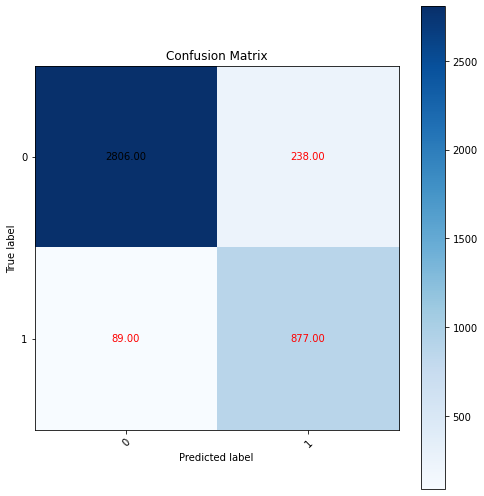

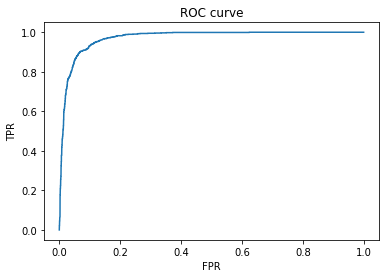

roc_auc:  0.9715650786395802


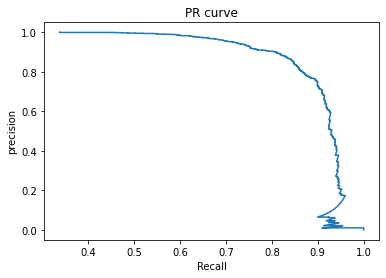

pr_auc:  0.897288742977993


In [39]:
X_train, X_val, y_train, y_val = train_test_split(X_train_bow, y_train_clf, test_size=0.20, random_state=42, stratify=y_train_clf)

multiNB = MultinomialNB()
multiNB.fit(X_train, y_train)
y_pred = multiNB.predict(X_val)
y_prob = multiNB.predict_proba(X_val)

acc, f1, precision, recall, roc_auc, pr_auc = model_eval(y_val, y_pred, y_prob)

drecap['bow+MultinomialNB'] = {'acc':acc, 
                               'f1':f1, 
                               'precision':precision, 
                               'recall':recall, 
                               'roc_aus':roc_auc, 
                               'pr_auc':pr_auc}

#### TFIDF

acc:  0.9224438902743142
f1:  0.82808181315644
recall:  0.7753623188405797
precision:  0.8884934756820878


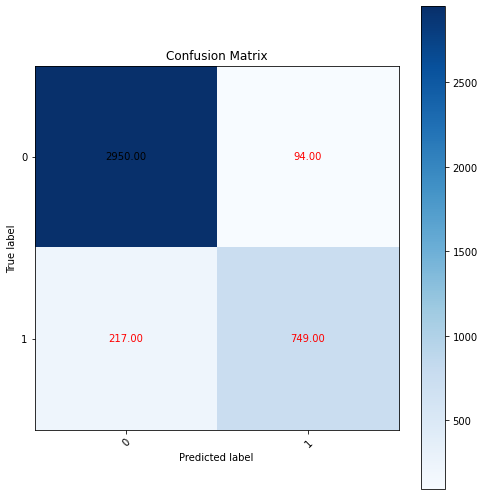

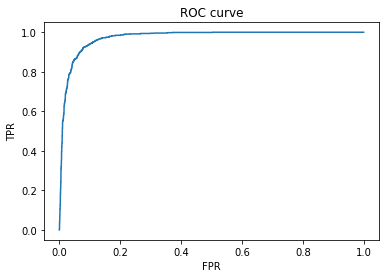

roc_auc:  0.9730954285387812


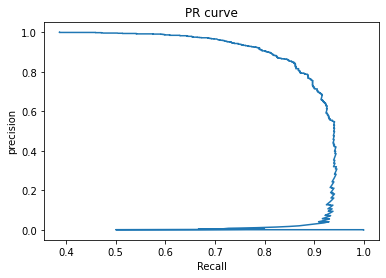

pr_auc:  0.8951063641844081


In [40]:

X_train, X_val, y_train, y_val = train_test_split(X_train_tfidf, y_train_clf, test_size=0.20, random_state=42, stratify=y_train_clf)

multiNB = MultinomialNB()
multiNB.fit(X_train, y_train)
y_pred = multiNB.predict(X_val)
y_prob = multiNB.predict_proba(X_val)

acc, f1, precision, recall, roc_auc, pr_auc = model_eval(y_val, y_pred, y_prob)

drecap['tfidf+MultinomialNB'] = {'acc':acc, 
                                 'f1':f1, 
                               'precision':precision, 
                               'recall':recall, 
                               'roc_aus':roc_auc, 
                               'pr_auc':pr_auc}

We see that the MultinomialNB is preforming very well with an accuracy more than 90%. We notice also its behavior change with BOW or TFIDF, in fact its affects the recall and the precision.
1. With BOW we obtain precision=78% and recall=90%
2. With TFIDF we obtain precision=88% and recall=77%


### ComplementNB

#### Bag Of Words

acc:  0.8835411471321696
f1:  0.7991397849462366
recall:  0.9616977225672878
precision:  0.6835908756438558


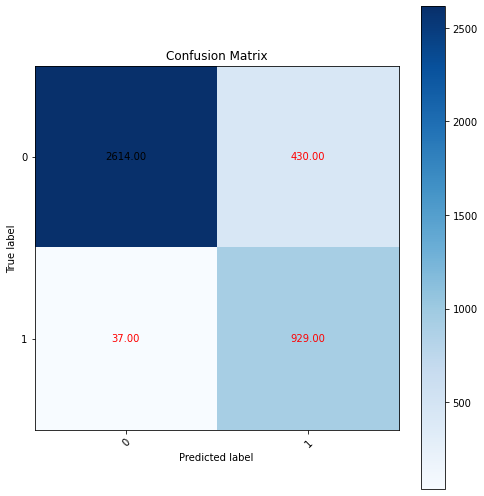

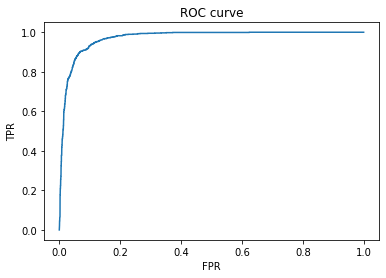

roc_auc:  0.9715633782508033


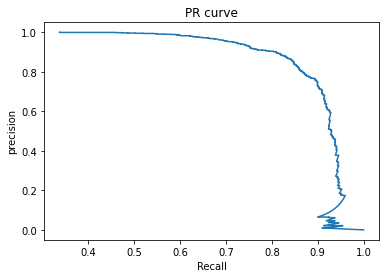

pr_auc:  0.8968181990291881


In [41]:
X_train, X_val, y_train, y_val = train_test_split(X_train_bow, y_train_clf, test_size=0.20, random_state=42, stratify=y_train_clf)

compNB = ComplementNB()
compNB.fit(X_train, y_train)
y_pred = compNB.predict(X_val)
y_prob = compNB.predict_proba(X_val)

acc, f1, precision, recall, roc_auc, pr_auc = model_eval(y_val, y_pred, y_prob)

drecap['bow+ComplementNB'] = {'acc':acc, 
                              'f1':f1, 
                               'precision':precision, 
                               'recall':recall, 
                               'roc_aus':roc_auc, 
                               'pr_auc':pr_auc}

#### TFIDF

acc:  0.8945137157107232
f1:  0.8145550197281893
recall:  0.9616977225672878
precision:  0.7064638783269962


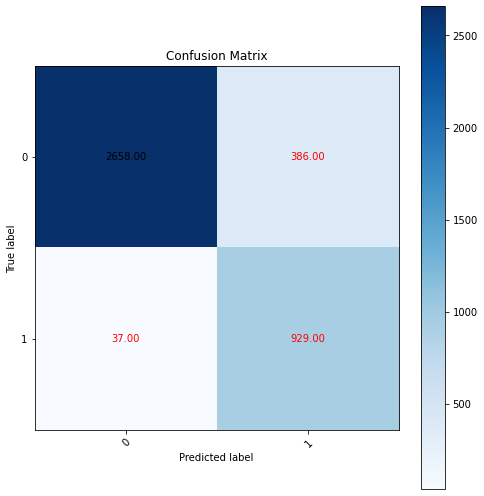

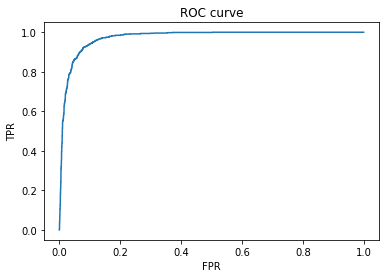

roc_auc:  0.9730954285387812


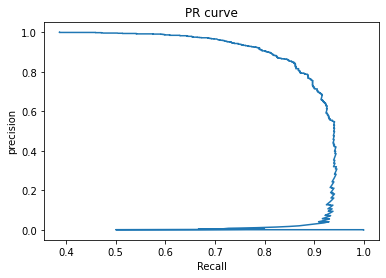

pr_auc:  0.8951063641844081


In [42]:
X_train, X_val, y_train, y_val = train_test_split(X_train_tfidf, y_train_clf, test_size=0.20, random_state=42, stratify=y_train_clf)

compNB = ComplementNB()
compNB.fit(X_train, y_train)
y_pred = compNB.predict(X_val)
y_prob = compNB.predict_proba(X_val)

acc, f1, precision, recall, roc_auc, pr_auc = model_eval(y_val, y_pred, y_prob)

drecap['tfidf+ComplementNB'] = {'acc':acc, 
                                'f1':f1, 
                               'precision':precision, 
                               'recall':recall, 
                               'roc_aus':roc_auc, 
                               'pr_auc':pr_auc}

We see that the ComplementNB is preforming very well also with an accuracy around 88%. However its behavior doesn't really change according to the term-occurence matrix used.

In [43]:
df_model_recap = pd.DataFrame(drecap).T

## Models Evaluation Summary

In [44]:
df_model_recap

,acc,f1,precision,recall,roc_aus,pr_auc
bow+MultinomialNB,0.918454,0.842864,0.786547,0.907867,0.971565,0.897289
tfidf+MultinomialNB,0.922444,0.828082,0.888493,0.775362,0.973095,0.895106
bow+ComplementNB,0.883541,0.799140,0.683591,0.961698,0.971563,0.896818
tfidf+ComplementNB,0.894514,0.814555,0.706464,0.961698,0.973095,0.895106


First of all the four models are performing very well according to their AUC from the ROC curve and Precision-Recall curve. Moreover their accuracy and f1 score are good.

If we refine our objectif we can choose one of them which fits better.

The solutions with the **ComplementNB** method have a better recall and lower precision. It can be a good choice if we want to detect a maximum of harmfull speeches while accepting a certain proportion of false negatif. In that scenario I choose the **tfidf+ComplementNB** with a recall of 96% and a precision of 70%

Another distinction is about the term occurence matrix used: With TFIDF we obtain a better precision than using BOW.

In other hands, with the scenario where the precision is more important, the model **tfidf+Multinomial** will be a better choice.

Finaly, I will choose the **bow+MultinomailNB** because it has the best balance between precision and recall with the higher f1 score : 84.28

## Improvements

In keeping the same process: 
1. Modify parameters of the term-occurences matrices - add more vocab - use trigram
2. Use cross validation 
3. Tune the smoothing parameter of ComplementNB

Several solutions can be fit this problem, this is one I would want to try : **BERT embedding + Supervised UMAP + SVM** 
Transformers (like BERT) have the advantages to not depend on the vocab from the dataset you are using because they are already trained on really huge amount of data. In addidtion, BERT understand the context of the text and adapt its embedding according to it. UMAP is diemension reduction method which understand in a macro and micro wise the connections between the diemnsions, in a supervised way it  can put forward the harmfull speeches.

# Predict on Test Set

In [58]:
df_test['Clean_text'] = df_test.Text.apply(lambda t: clean_text(t))

In [59]:
crorpus_test = df_test.Clean_text.values.tolist()

In [60]:
X_test = bow.transform(crorpus_test).toarray()

In [61]:
multiNB = MultinomialNB()
multiNB.fit(X_train_bow, y_train_clf)
y_pred = multiNB.predict(X_test)
y_prob = multiNB.predict_proba(X_test)

In [63]:
file1 = open("gdrive/My Drive/FAT-GROUP Home Assignement/test_prediction.txt","w") 
for p in y_pred:
  file1.write(str(p)+'\n') 
file1.close()